In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)
        plt.xticks(rotation=45)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [6]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [7]:
def add_month(df):
    new_index = [] 
    for i, index_value in enumerate(df.index):
        iteration = i % 12 + 1
        new_index.append(f'{index_value}-{iteration}')
    df.index = new_index

    return df

In [8]:
def read_csv_replace_missing_by_polynomial(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=1)
        df = df.iloc[:, 2:-1]
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 2:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_filler(df[col])
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

In [9]:
df = read_csv_replace_missing_by_polynomial('idh.csv')
df = df.T
header = df.iloc[0]
df = df[1:]
df.columns = header
df

Estado,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
1980,0.506,0.41,0.608,0.582,0.515,0.44,0.751,0.673,0.66,0.405,...,0.7,0.733,0.444,0.595,0.679,0.744,0.734,0.477,0.728,0.465
1991,0.584,0.474,0.658,0.687,0.53,0.517,0.806,0.704,0.722,0.456,...,0.76,0.782,0.539,0.635,0.728,0.786,0.785,0.539,0.787,0.56
2012,0.701,0.651,0.691,0.707,0.678,0.701,0.825,0.758,0.744,0.648,...,0.772,0.762,0.695,0.694,0.738,0.763,0.792,0.684,0.812,0.71
2013,0.706,0.648,0.702,0.734,0.68,0.705,0.837,0.765,0.752,0.661,...,0.782,0.768,0.71,0.687,0.738,0.773,0.801,0.683,0.818,0.719
2014,0.715,0.666,0.706,0.725,0.694,0.71,0.836,0.772,0.757,0.663,...,0.788,0.78,0.723,0.692,0.744,0.779,0.807,0.696,0.825,0.737
2015,0.718,0.666,0.711,0.728,0.701,0.715,0.837,0.776,0.755,0.669,...,0.786,0.785,0.733,0.706,0.748,0.787,0.809,0.697,0.823,0.73
2016,0.723,0.68,0.711,0.733,0.705,0.722,0.847,0.779,0.764,0.68,...,0.797,0.789,0.732,0.715,0.752,0.789,0.814,0.697,0.835,0.734
2017,0.712,0.679,0.728,0.732,0.71,0.73,0.842,0.78,0.765,0.685,...,0.797,0.791,0.728,0.721,0.746,0.793,0.817,0.699,0.831,0.74
2018,0.733,0.689,0.718,0.741,0.71,0.739,0.845,0.788,0.771,0.686,...,0.805,0.805,0.739,0.73,0.76,0.797,0.819,0.71,0.837,0.749
2019,0.739,0.687,0.726,0.737,0.718,0.744,0.859,0.793,0.774,0.694,...,0.807,0.809,0.742,0.73,0.749,0.801,0.826,0.705,0.845,0.751


In [10]:
df['Ano'] = df.index
df = df.reset_index(drop=True)
print(df['Ano'])
missing_years = list(range(1981, 1991)) + list(range(1992, 2012)) + list(range(2022, 2023))

for year in missing_years: 
    novo_ano = pd.Series({'Ano': year})
    df = df.append(novo_ano, ignore_index=True)
    
df['Ano'] = df['Ano'].astype(int)    
df = df.sort_values('Ano', ascending=True)
df = df.set_index('Ano')
df.to_csv('idh_para_interpolacao.csv', index=True)
display(df)

0     1980
1     1991
2     2012
3     2013
4     2014
5     2015
6     2016
7     2017
8     2018
9     2019
10    2020
11    2021
Name: Ano, dtype: object


,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1980,0.506,0.41,0.608,0.582,0.515,0.44,0.751,0.673,0.66,0.405,...,0.7,0.733,0.444,0.595,0.679,0.744,0.734,0.477,0.728,0.465
1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
def read_csv_replace_missing_by_polynomial_2(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

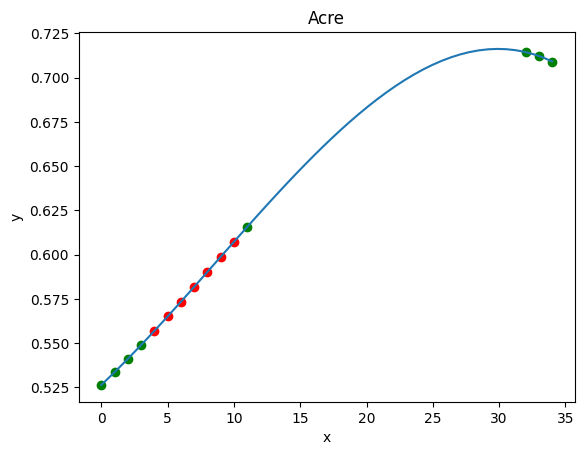

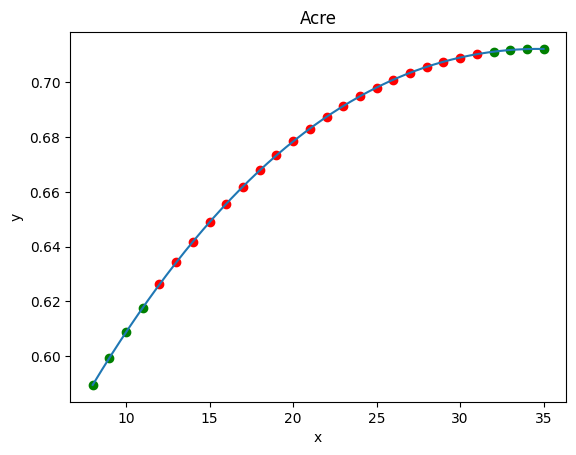

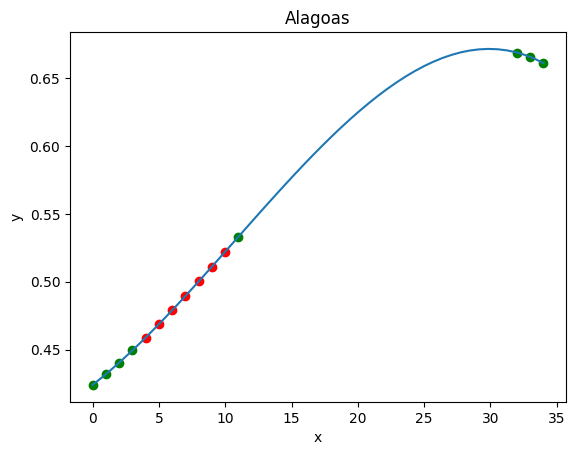

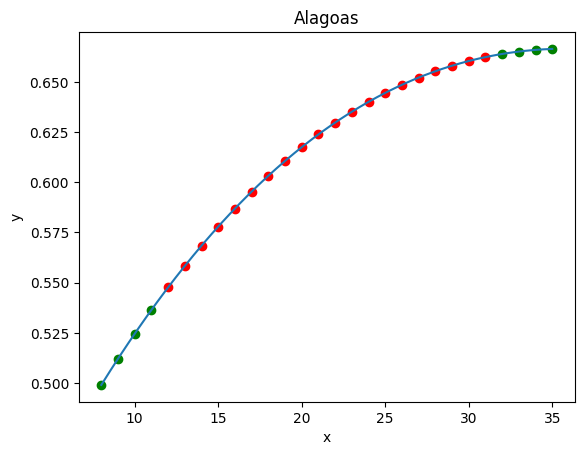

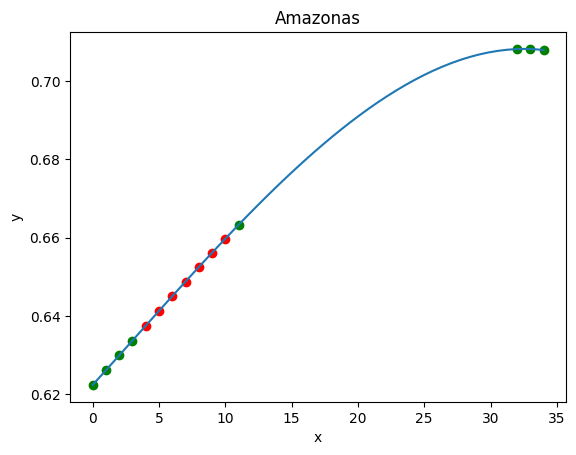

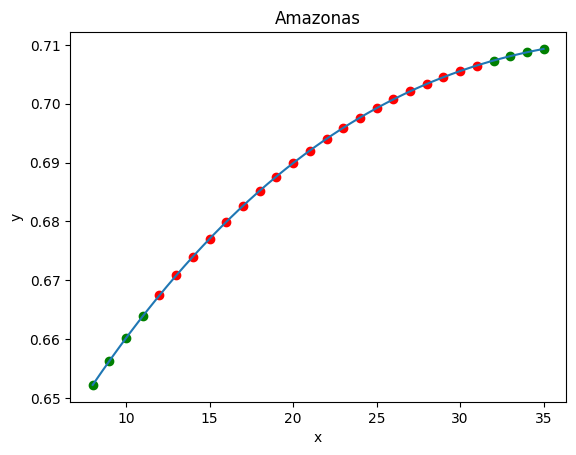

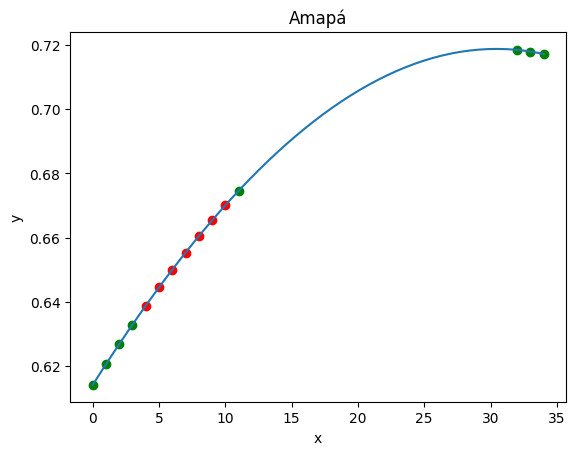

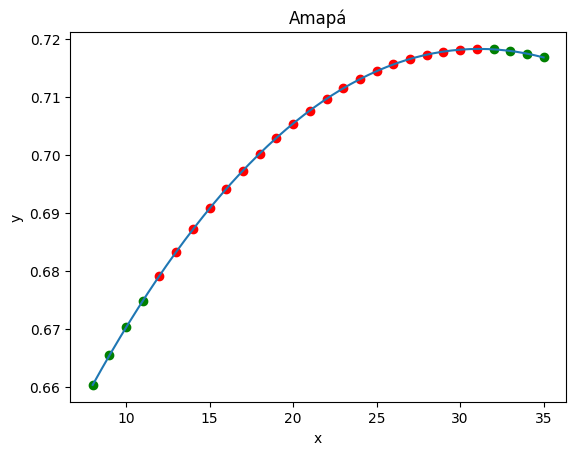

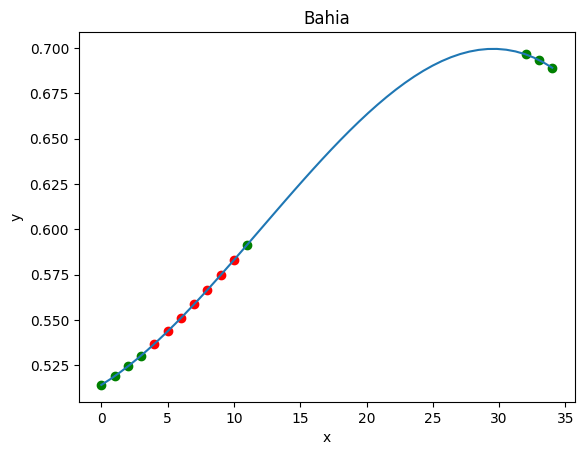

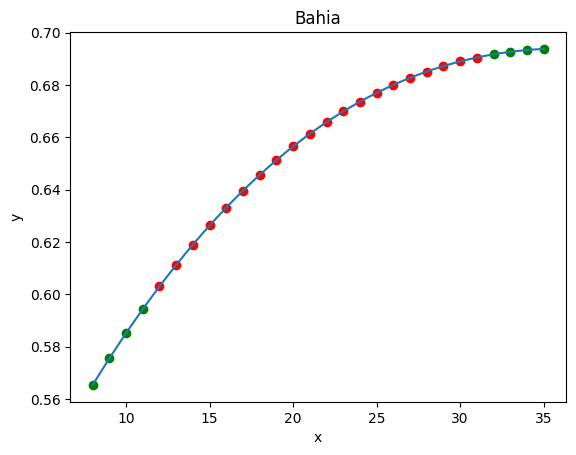

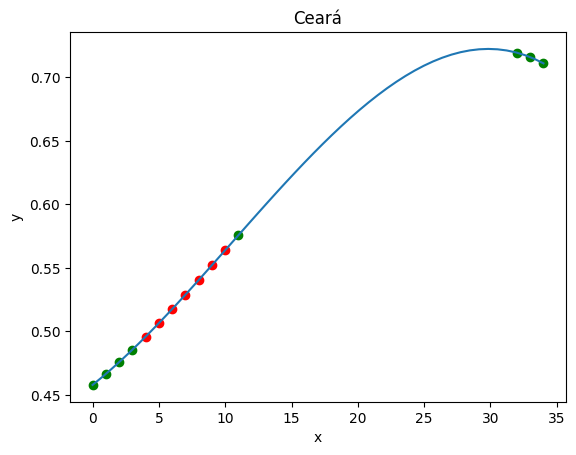

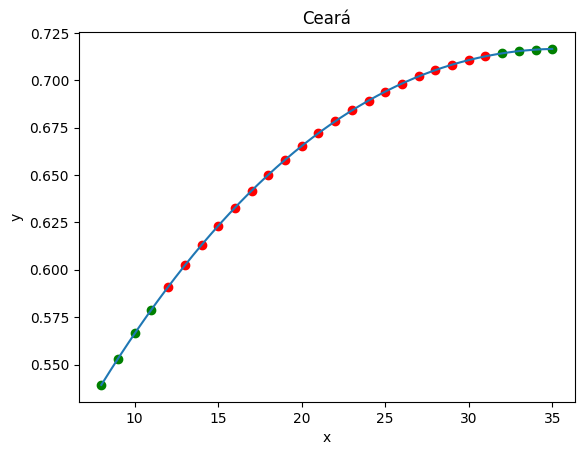

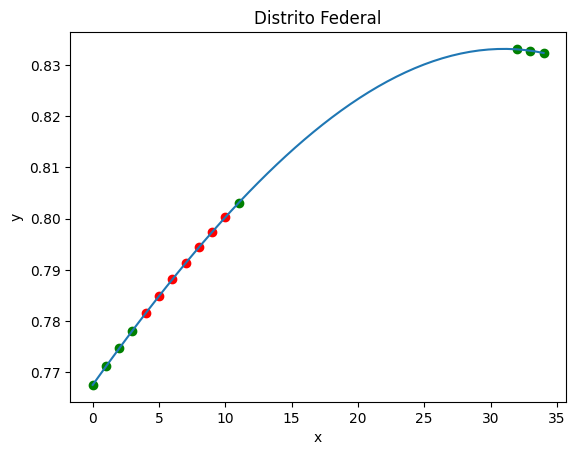

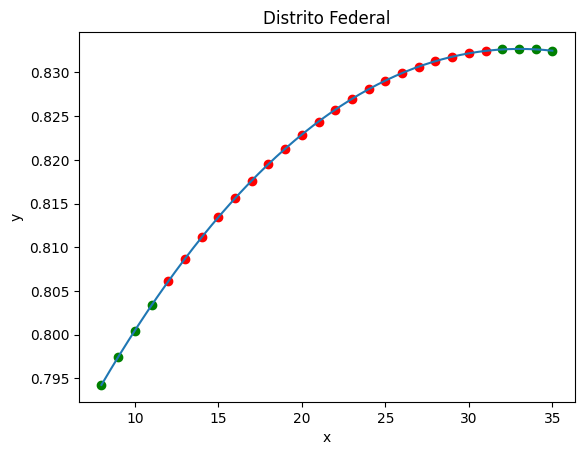

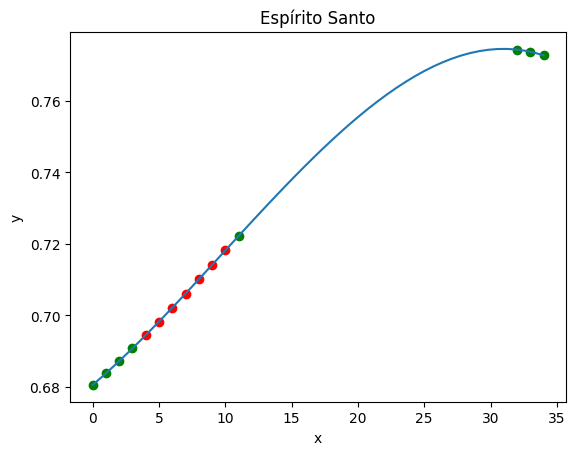

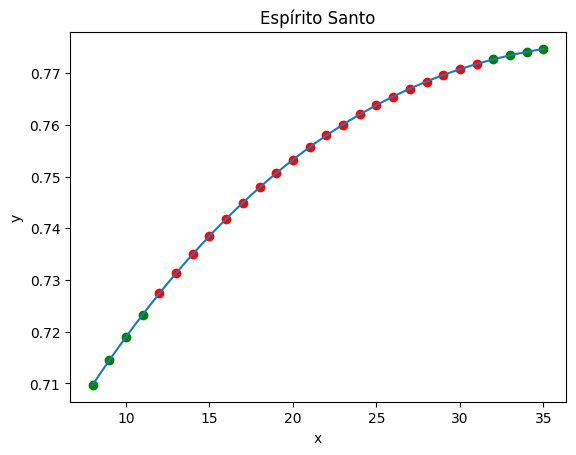

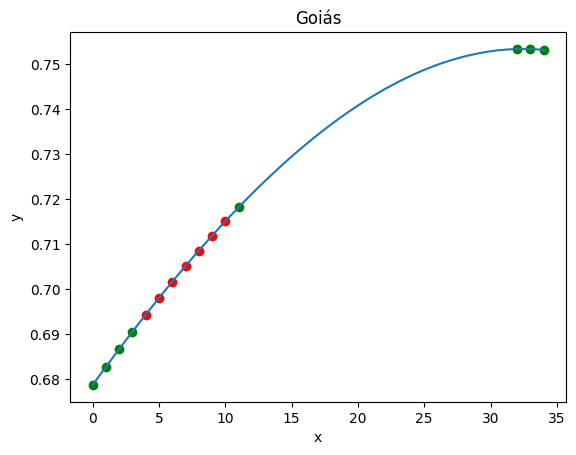

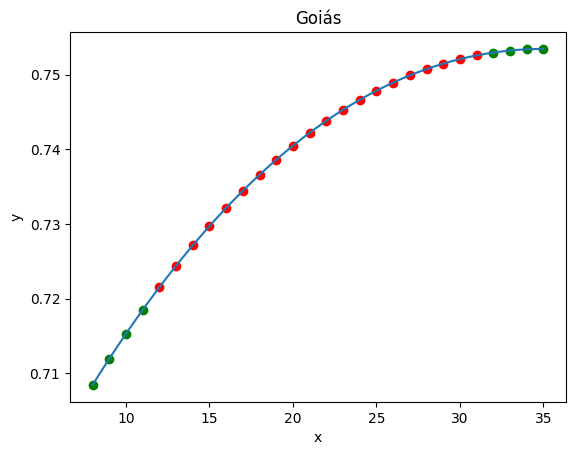

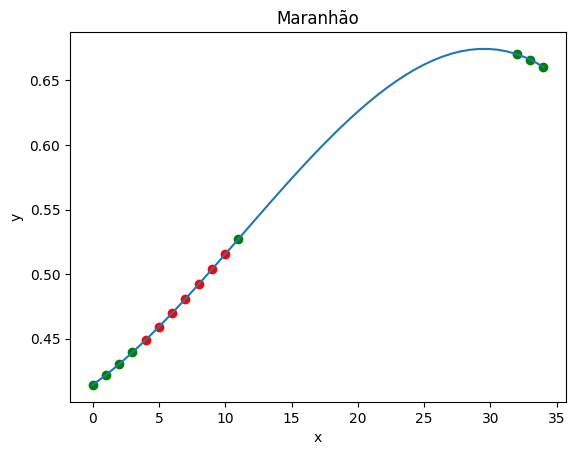

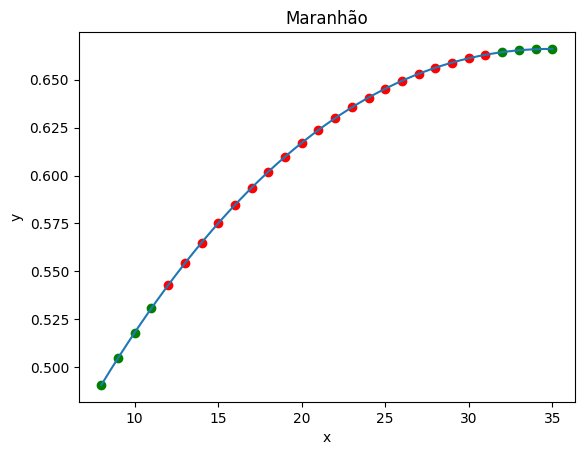

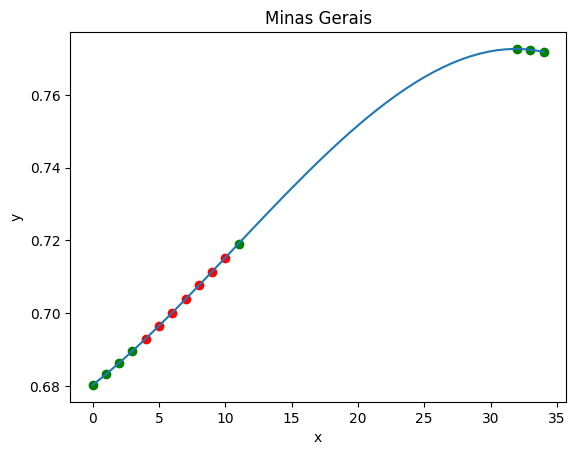

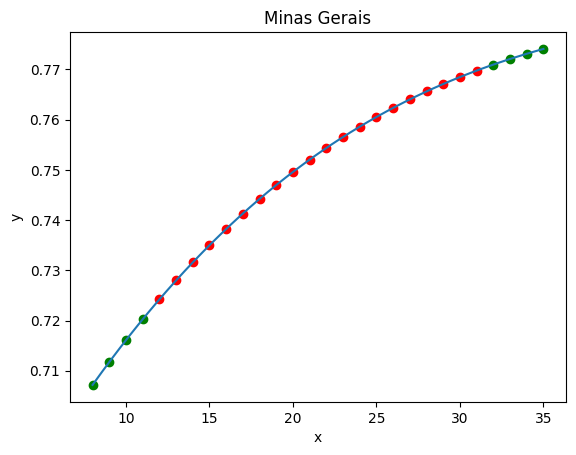

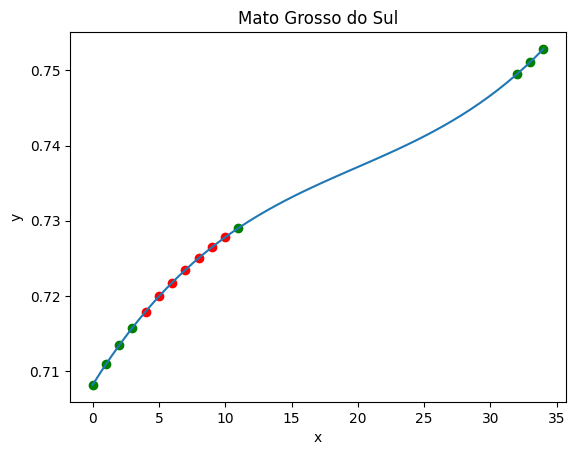

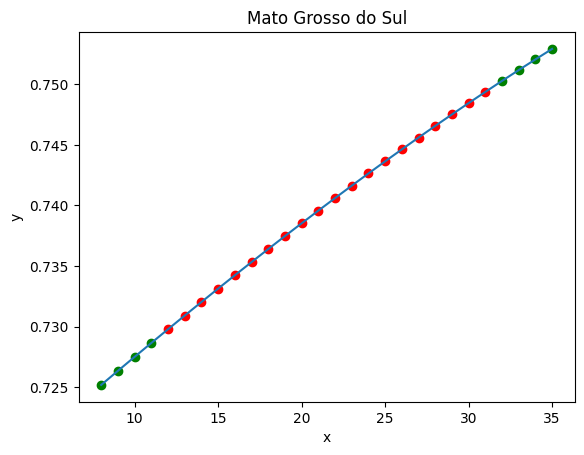

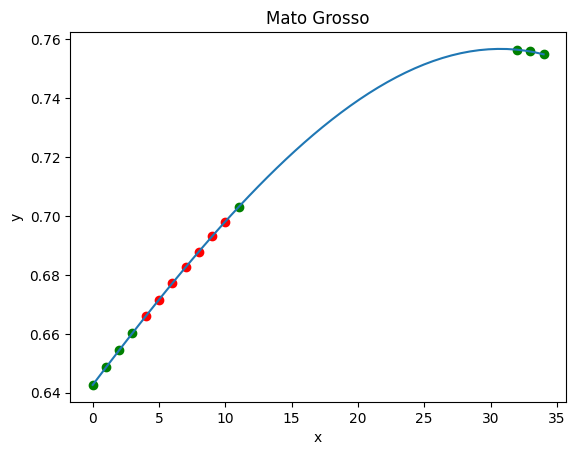

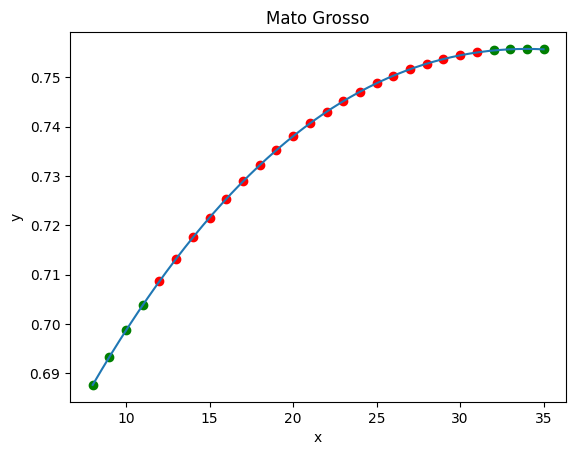

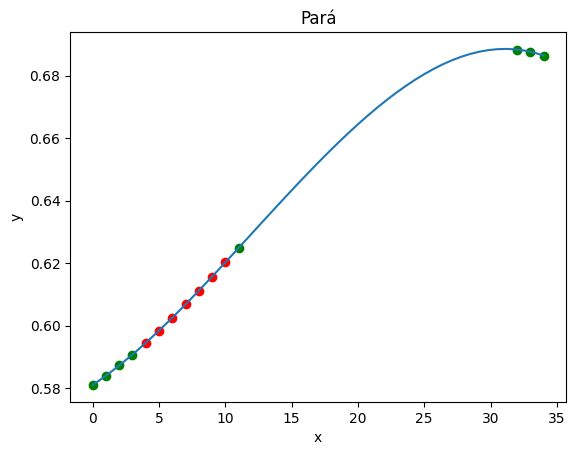

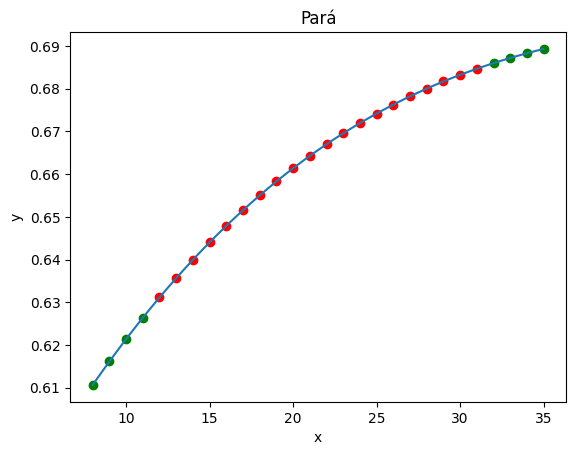

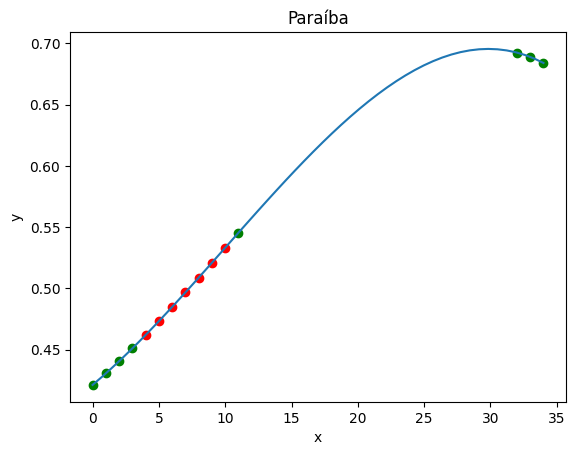

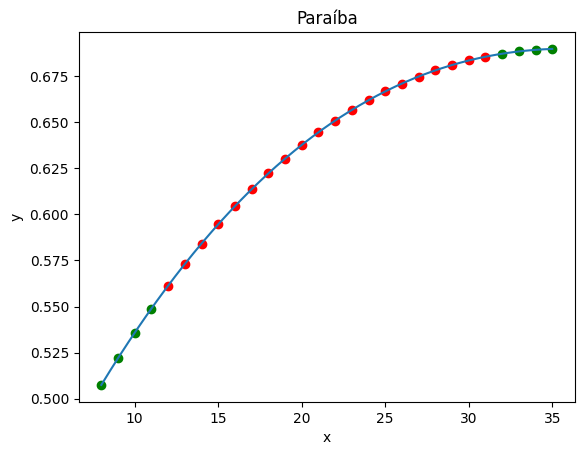

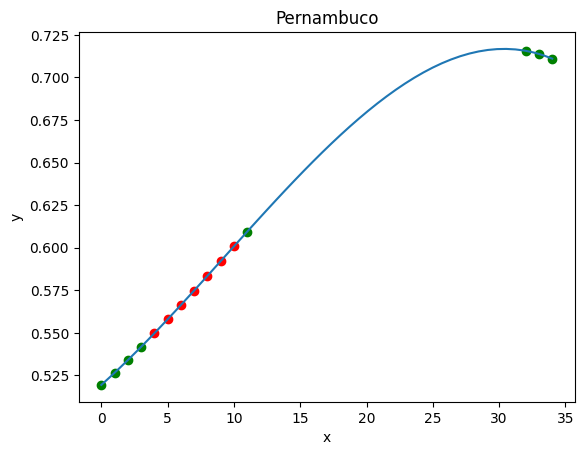

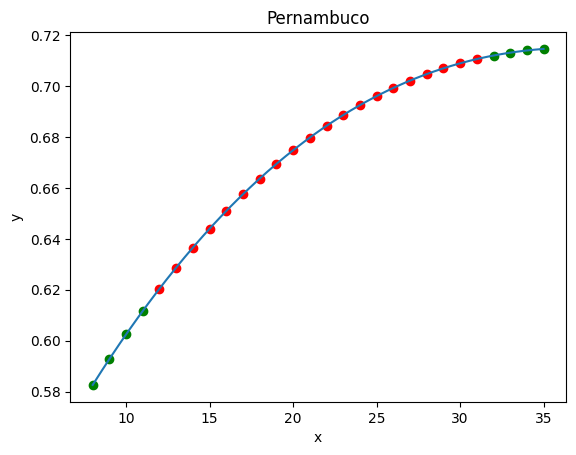

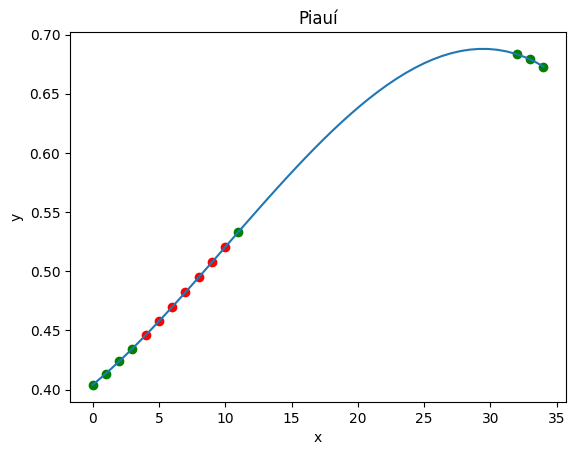

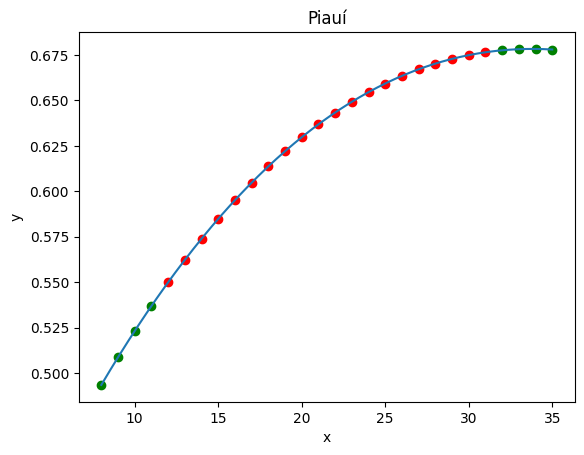

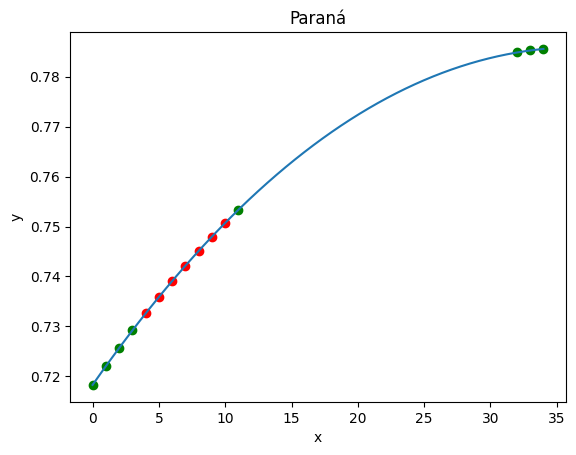

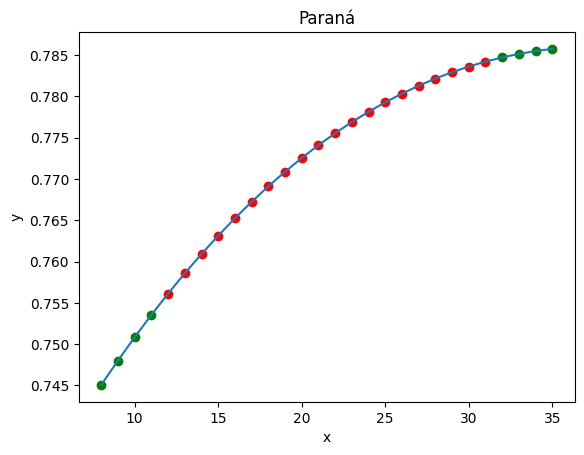

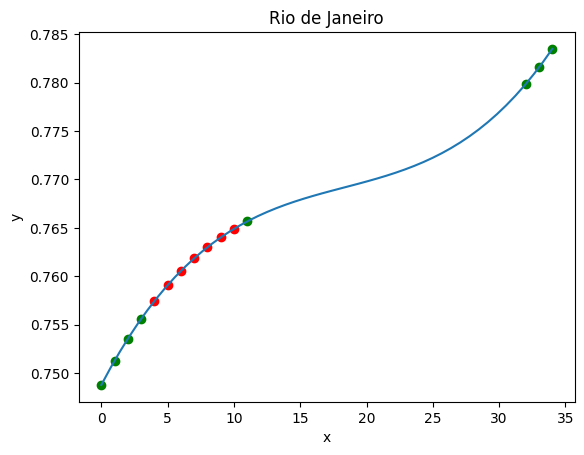

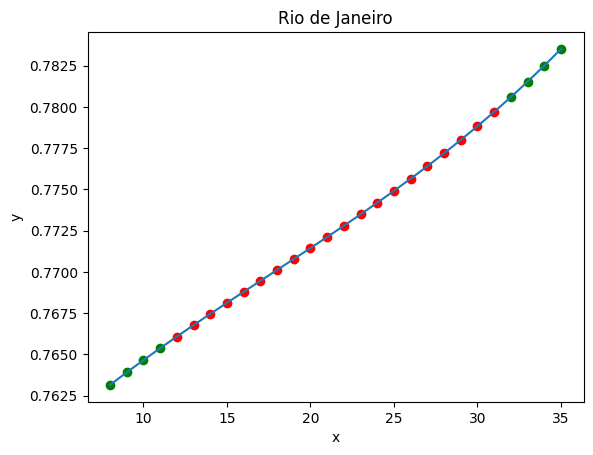

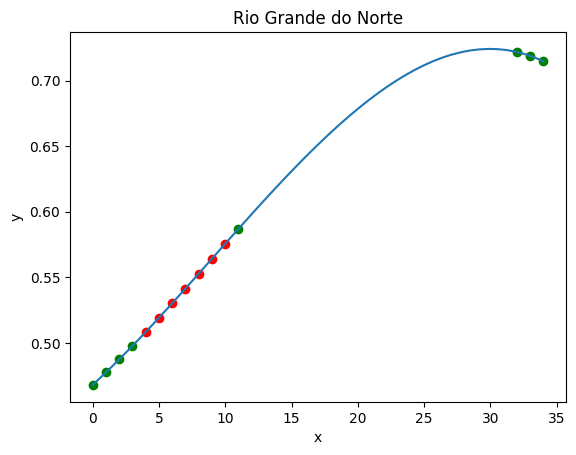

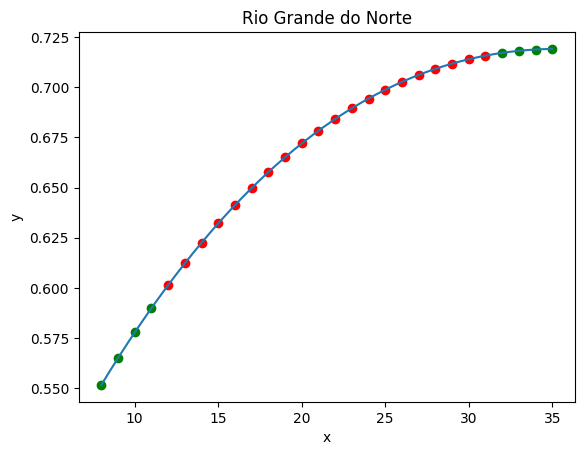

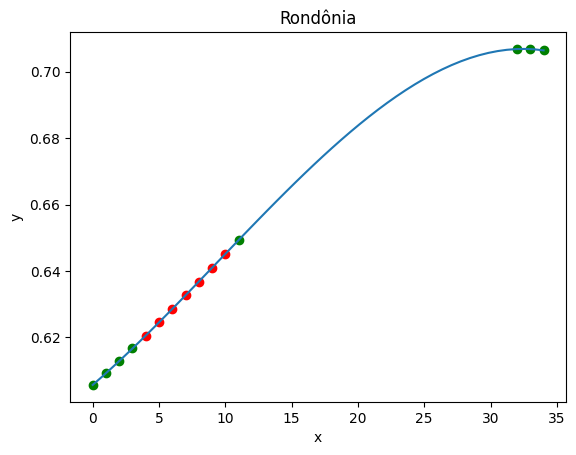

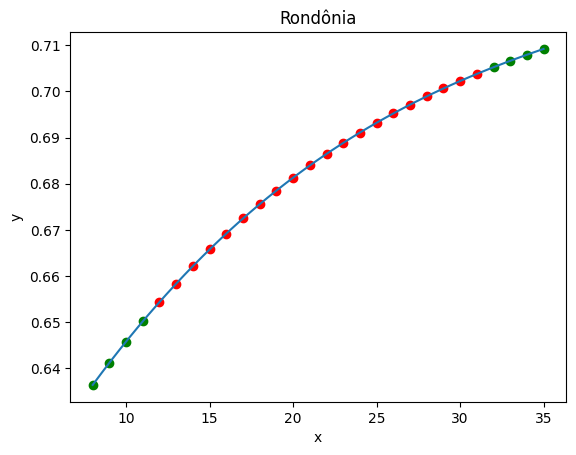

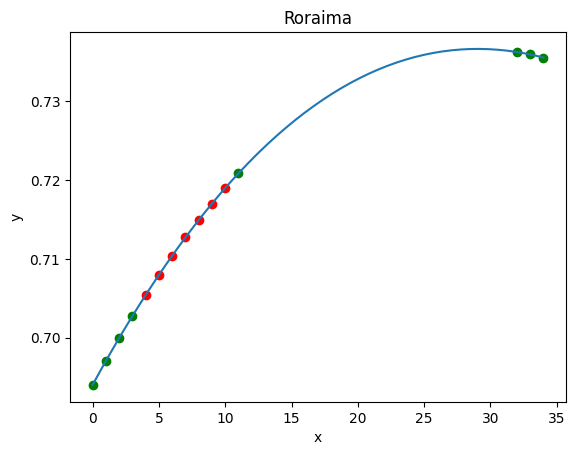

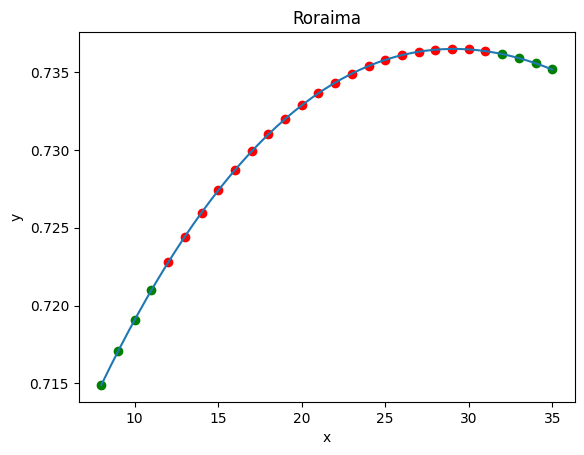

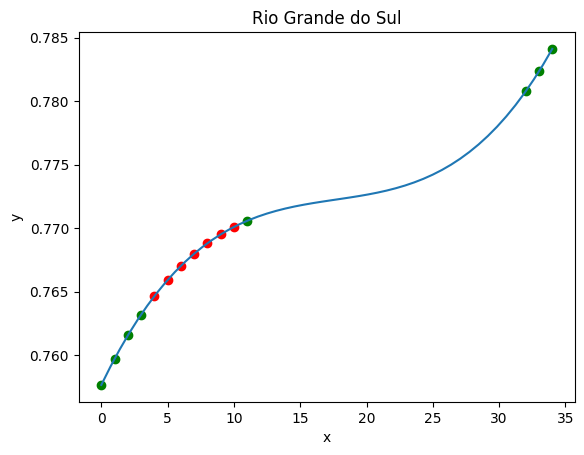

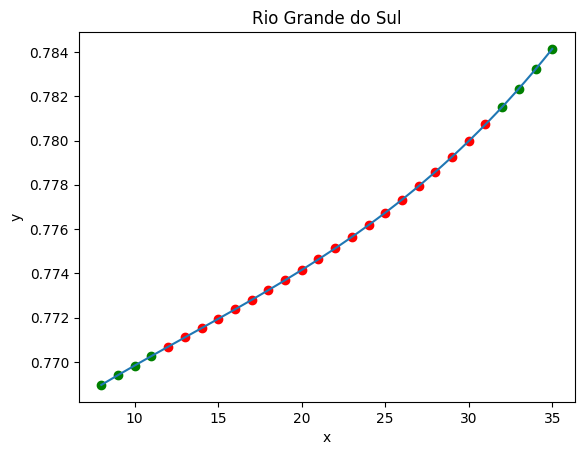

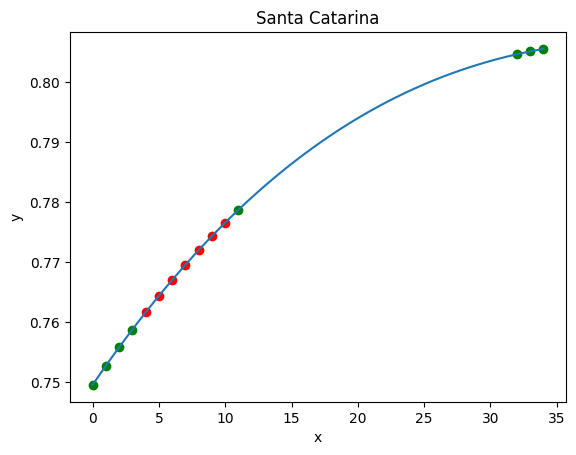

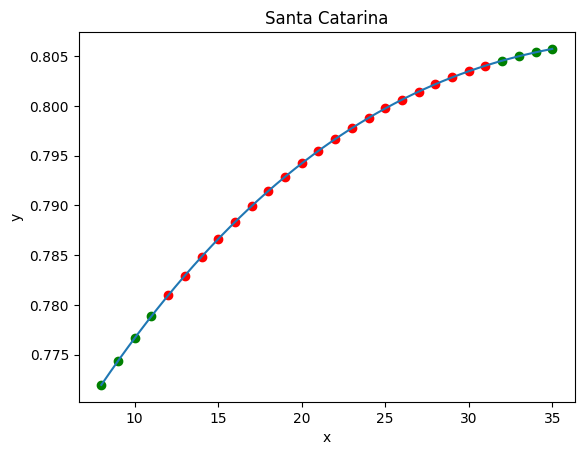

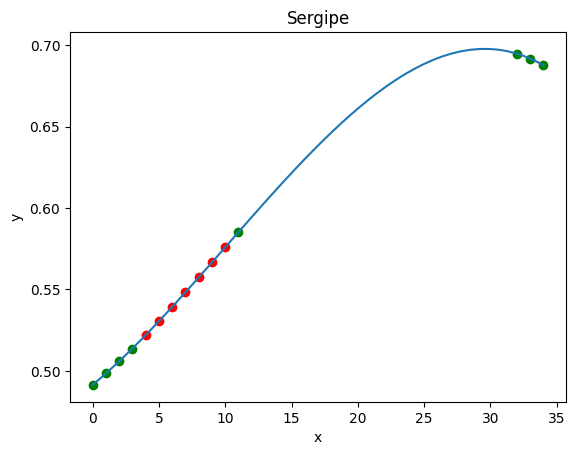

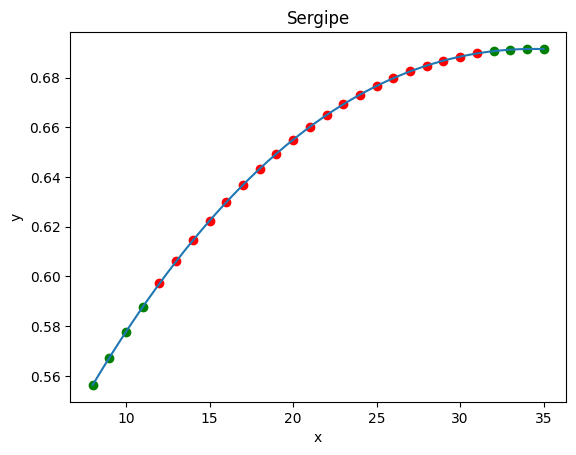

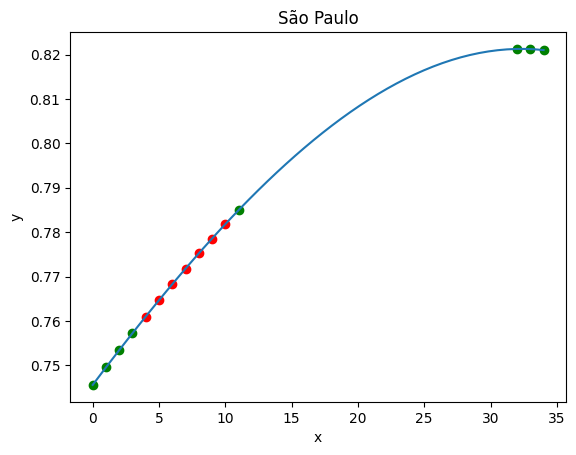

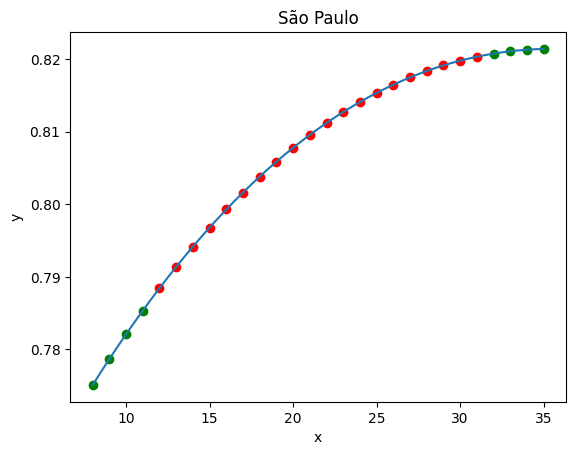

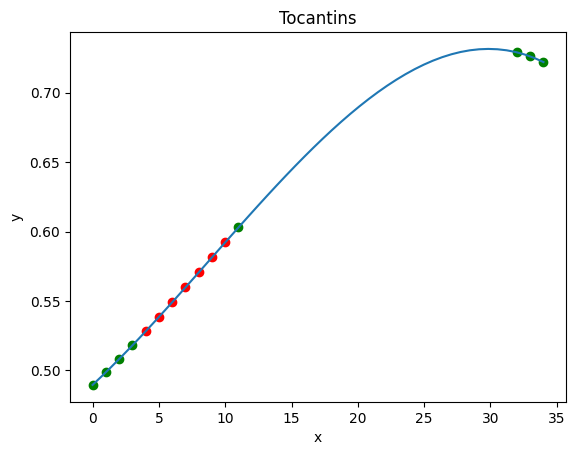

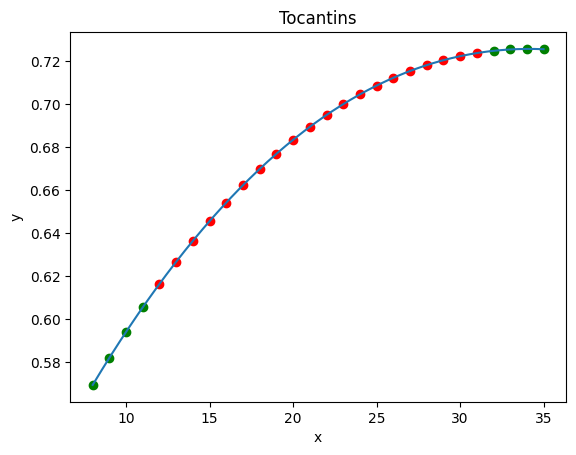

,Acre - IDH,Alagoas - IDH,Amazonas - IDH,Amapá - IDH,Bahia - IDH,Ceará - IDH,Distrito Federal - IDH,Espírito Santo - IDH,Goiás - IDH,Maranhão - IDH,...,Paraná - IDH,Rio de Janeiro - IDH,Rio Grande do Norte - IDH,Rondônia - IDH,Roraima - IDH,Rio Grande do Sul - IDH,Santa Catarina - IDH,Sergipe - IDH,São Paulo - IDH,Tocantins - IDH
Ano,,,,,,,,,,,,,,,,,,,,,
1980,0.530109,0.429782,0.623455,0.614455,0.519636,0.463800,0.768000,0.682582,0.679164,0.420764,...,0.718545,0.748145,0.473364,0.607364,0.694145,0.756982,0.749764,0.496164,0.746236,0.494364
1981,0.534931,0.433738,0.626545,0.620945,0.520564,0.468560,0.771400,0.684498,0.682996,0.423916,...,0.722255,0.751175,0.479236,0.609836,0.697175,0.759578,0.752916,0.499996,0.749884,0.500236
1982,0.539299,0.437322,0.629345,0.626825,0.521404,0.472872,0.774480,0.686234,0.686468,0.426772,...,0.725615,0.753919,0.484556,0.612076,0.699919,0.761930,0.755772,0.503468,0.753188,0.505556
1983,0.543122,0.440459,0.631796,0.631972,0.522139,0.476646,0.777176,0.687754,0.689507,0.429272,...,0.728556,0.756320,0.489213,0.614037,0.702320,0.763989,0.758272,0.506507,0.756080,0.510213
1984,0.556928,0.458831,0.637476,0.638824,0.536747,0.495920,0.781535,0.694497,0.694308,0.448942,...,0.732599,0.757429,0.508190,0.620560,0.705409,0.764636,0.761638,0.521980,0.761013,0.528017
1985,0.565096,0.468727,0.641261,0.644521,0.543667,0.506607,0.784862,0.698285,0.698004,0.459129,...,0.735894,0.759077,0.519057,0.624531,0.707964,0.765911,0.764385,0.530501,0.764689,0.538391
1986,0.573402,0.478969,0.645028,0.650026,0.550978,0.517643,0.788111,0.702161,0.701608,0.469765,...,0.739078,0.760545,0.530139,0.628573,0.710401,0.767022,0.767027,0.539275,0.768286,0.548955
1987,0.581808,0.489497,0.648768,0.655336,0.558625,0.528964,0.791279,0.706106,0.705118,0.480778,...,0.742152,0.761846,0.541383,0.632671,0.712722,0.767983,0.769566,0.548253,0.771802,0.559661
1988,0.590277,0.500251,0.652473,0.660449,0.566551,0.540508,0.794361,0.710102,0.708531,0.492098,...,0.745117,0.762995,0.552736,0.636807,0.714929,0.768806,0.772003,0.557384,0.775232,0.570459


In [12]:
df = read_csv_replace_missing_by_polynomial_2('idh_para_interpolacao.csv')
df = df.set_index('Ano')
df.columns = df.columns + ' - IDH'
df

In [13]:
df_2003 = df[df.index >= 2003]
df_2003

,Acre - IDH,Alagoas - IDH,Amazonas - IDH,Amapá - IDH,Bahia - IDH,Ceará - IDH,Distrito Federal - IDH,Espírito Santo - IDH,Goiás - IDH,Maranhão - IDH,...,Paraná - IDH,Rio de Janeiro - IDH,Rio Grande do Norte - IDH,Rondônia - IDH,Roraima - IDH,Rio Grande do Sul - IDH,Santa Catarina - IDH,Sergipe - IDH,São Paulo - IDH,Tocantins - IDH
Ano,,,,,,,,,,,,,,,,,,,,,
2003,0.691320,0.635160,0.695898,0.711421,0.669899,0.684040,0.826971,0.760059,0.745293,0.635570,...,0.776871,0.773489,0.689488,0.688843,0.734916,0.775641,0.797768,0.669217,0.812723,0.700107
2004,0.694888,0.640093,0.697632,0.713006,0.673628,0.689267,0.828078,0.762013,0.746636,0.640694,...,0.778118,0.774193,0.694345,0.691090,0.735404,0.776178,0.798794,0.673124,0.814104,0.704664
2005,0.698098,0.644568,0.699241,0.714376,0.677007,0.694000,0.829060,0.763817,0.747851,0.645312,...,0.779266,0.774914,0.698728,0.693216,0.735800,0.776738,0.799746,0.676629,0.815359,0.708752
2006,0.700957,0.648597,0.700728,0.715533,0.680049,0.698250,0.829921,0.765477,0.748941,0.649437,...,0.780317,0.775653,0.702649,0.695228,0.736105,0.777325,0.800627,0.679740,0.816488,0.712378
2007,0.703473,0.652189,0.702099,0.716480,0.682761,0.702028,0.830662,0.766998,0.749908,0.653077,...,0.781274,0.776412,0.706119,0.697131,0.736322,0.777940,0.801440,0.682466,0.817495,0.715551
2008,0.705654,0.655354,0.703356,0.717218,0.685154,0.705344,0.831284,0.768383,0.750753,0.656244,...,0.782138,0.777194,0.709150,0.698932,0.736454,0.778585,0.802185,0.684816,0.818381,0.718281
2009,0.707507,0.658104,0.704503,0.717750,0.687239,0.708210,0.831790,0.769638,0.751479,0.658950,...,0.782910,0.778002,0.711755,0.700638,0.736503,0.779263,0.802866,0.686798,0.819150,0.720575
2010,0.709040,0.660450,0.705545,0.718079,0.689024,0.710635,0.832181,0.770767,0.752088,0.661204,...,0.783594,0.778838,0.713945,0.702254,0.736471,0.779976,0.803485,0.688421,0.819803,0.722443
2011,0.710262,0.662401,0.706485,0.718205,0.690520,0.712630,0.832459,0.771775,0.752581,0.663017,...,0.784190,0.779704,0.715731,0.703786,0.736360,0.780726,0.804044,0.689694,0.820344,0.723894


In [16]:
def dataframe_expanded_interpolation(df):
    expanded_df = pd.DataFrame(columns=df.columns)
    for i, (_, row) in enumerate(df.iterrows()):
        if i > 0:
            expanded_df = pd.concat([expanded_df, pd.DataFrame(columns=df.columns, index=[None] * 11)])
        expanded_df = pd.concat([expanded_df, pd.DataFrame(row).T])
    expanded_df = expanded_df.reset_index(drop=True)
    expanded_df.interpolate(method='linear', axis=0, inplace=True)

    return expanded_df

def add_ano_column(df):
    new_df = df.copy()
    ano_start = 2002
    for i in range(len(new_df)):
        if i % 12 == 0:
            ano_start += 1
        new_df.at[i, 'Ano'] =  str(ano_start)

    return new_df

In [17]:
pd.set_option('display.max_rows', None)
df_mo_2003 = dataframe_expanded_interpolation(df_2003)
df_mo_2003 = add_ano_column(df_mo_2003)
df_mo_2003 = df_mo_2003.set_index('Ano', inplace=False)
df_mo_2003 = add_month(df_mo_2003)
df_mo_2003

,Acre - IDH,Alagoas - IDH,Amazonas - IDH,Amapá - IDH,Bahia - IDH,Ceará - IDH,Distrito Federal - IDH,Espírito Santo - IDH,Goiás - IDH,Maranhão - IDH,...,Paraná - IDH,Rio de Janeiro - IDH,Rio Grande do Norte - IDH,Rondônia - IDH,Roraima - IDH,Rio Grande do Sul - IDH,Santa Catarina - IDH,Sergipe - IDH,São Paulo - IDH,Tocantins - IDH
2003-1,0.691320,0.635160,0.695898,0.711421,0.669899,0.684040,0.826971,0.760059,0.745293,0.635570,...,0.776871,0.773489,0.689488,0.688843,0.734916,0.775641,0.797768,0.669217,0.812723,0.700107
2003-2,0.691617,0.635571,0.696043,0.711553,0.670210,0.684476,0.827063,0.760222,0.745405,0.635997,...,0.776975,0.773547,0.689892,0.689031,0.734957,0.775686,0.797853,0.669542,0.812838,0.700487
2003-3,0.691914,0.635982,0.696187,0.711685,0.670521,0.684912,0.827155,0.760385,0.745517,0.636424,...,0.777079,0.773606,0.690297,0.689218,0.734998,0.775731,0.797939,0.669868,0.812953,0.700866
2003-4,0.692212,0.636393,0.696332,0.711817,0.670831,0.685347,0.827247,0.760548,0.745629,0.636851,...,0.777183,0.773665,0.690702,0.689405,0.735038,0.775775,0.798024,0.670193,0.813068,0.701246
2003-5,0.692509,0.636804,0.696476,0.711949,0.671142,0.685783,0.827340,0.760710,0.745741,0.637278,...,0.777287,0.773724,0.691107,0.689592,0.735079,0.775820,0.798110,0.670519,0.813183,0.701626
2003-6,0.692806,0.637215,0.696621,0.712081,0.671453,0.686218,0.827432,0.760873,0.745853,0.637705,...,0.777391,0.773782,0.691512,0.689780,0.735120,0.775865,0.798195,0.670845,0.813299,0.702006
2003-7,0.693104,0.637626,0.696765,0.712213,0.671763,0.686654,0.827524,0.761036,0.745965,0.638132,...,0.777495,0.773841,0.691916,0.689967,0.735160,0.775909,0.798281,0.671170,0.813414,0.702386
2003-8,0.693401,0.638037,0.696910,0.712345,0.672074,0.687089,0.827616,0.761199,0.746077,0.638559,...,0.777598,0.773900,0.692321,0.690154,0.735201,0.775954,0.798366,0.671496,0.813529,0.702765
2003-9,0.693699,0.638448,0.697054,0.712477,0.672385,0.687525,0.827709,0.761362,0.746189,0.638986,...,0.777702,0.773959,0.692726,0.690341,0.735242,0.775999,0.798452,0.671822,0.813644,0.703145
2003-10,0.693996,0.638860,0.697199,0.712609,0.672696,0.687960,0.827801,0.761524,0.746301,0.639413,...,0.777806,0.774017,0.693131,0.690528,0.735282,0.776044,0.798537,0.672147,0.813759,0.703525


In [18]:
for column in df_mo_2003.columns:
    file_name = f"2003_mo_{column}.csv"
    column_df = df_mo_2003[[column]])
    column_df.to_csv(file_name, index=True

In [13]:
for column in df_2003.columns:
    state = column
    file_name = f"2003_01_idh_{state}.csv"
    column_df = df_2003[[column]]
    column_df.to_csv(file_name, index=True)

In [12]:
df_2014 = df[df.index >= 2014]
df_2014

,Acre - IDH,Alagoas - IDH,Amazonas - IDH,Amapá - IDH,Bahia - IDH,Ceará - IDH,Distrito Federal - IDH,Espírito Santo - IDH,Goiás - IDH,Maranhão - IDH,...,Paraná - IDH,Rio de Janeiro - IDH,Rio Grande do Norte - IDH,Rondônia - IDH,Roraima - IDH,Rio Grande do Sul - IDH,Santa Catarina - IDH,Sergipe - IDH,São Paulo - IDH,Tocantins - IDH
Ano,,,,,,,,,,,,,,,,,,,,,
2014,0.721219,0.680590,0.712382,0.718540,0.702968,0.731083,0.833682,0.778933,0.755363,0.679876,...,0.787206,0.782625,0.732479,0.712774,0.733599,0.783585,0.806898,0.702763,0.823530,0.738395
2015,0.721738,0.681806,0.712914,0.718002,0.703716,0.732840,0.833489,0.779511,0.755226,0.681282,...,0.787140,0.782844,0.733269,0.714505,0.732732,0.783967,0.806890,0.703327,0.823407,0.738511
2016,0.722049,0.683123,0.713073,0.717168,0.703942,0.734326,0.833197,0.779803,0.755245,0.682305,...,0.787235,0.782664,0.733292,0.715214,0.731460,0.783714,0.806714,0.703854,0.823441,0.739220
2017,0.721970,0.683384,0.713246,0.715849,0.703854,0.735353,0.832046,0.779870,0.754516,0.682497,...,0.786421,0.782136,0.733399,0.715232,0.729748,0.783274,0.806107,0.704425,0.822478,0.739655
2018,0.722801,0.683749,0.712017,0.714503,0.703341,0.735800,0.831217,0.779859,0.753642,0.682289,...,0.785540,0.781397,0.733849,0.714751,0.728394,0.782463,0.805199,0.704877,0.821767,0.739626
2019,0.721951,0.683311,0.711518,0.712295,0.702787,0.735533,0.830068,0.779181,0.752196,0.681980,...,0.783918,0.779431,0.733420,0.713481,0.725760,0.781252,0.804049,0.704451,0.820498,0.738845
2020,0.720530,0.683004,0.710311,0.710236,0.701519,0.734827,0.827657,0.778029,0.750379,0.680978,...,0.781994,0.776966,0.732705,0.712104,0.723823,0.779606,0.802219,0.704405,0.818456,0.737832
2021,0.718407,0.682088,0.708920,0.709089,0.699645,0.733146,0.827545,0.776865,0.749743,0.679476,...,0.781577,0.776297,0.731264,0.709863,0.722559,0.779574,0.802154,0.702939,0.818078,0.736402
2022,0.719108,0.681928,0.709664,0.710847,0.700366,0.733075,0.828674,0.777354,0.750805,0.679766,...,0.782625,0.777488,0.731536,0.710685,0.724522,0.780288,0.803001,0.703017,0.819084,0.736852


In [13]:
for column in df_2014.columns:
    state = column
    file_name = f"2014_01_idh_{state}.csv"
    column_df = df_2014[[column]]
    column_df.to_csv(file_name, index=True)

In [26]:
df_2008 = df[df.index >= 2008]
df_2008

,Acre - IDH,Alagoas - IDH,Amazonas - IDH,Amapá - IDH,Bahia - IDH,Ceará - IDH,Distrito Federal - IDH,Espírito Santo - IDH,Goiás - IDH,Maranhão - IDH,...,Paraná - IDH,Rio de Janeiro - IDH,Rio Grande do Norte - IDH,Rondônia - IDH,Roraima - IDH,Rio Grande do Sul - IDH,Santa Catarina - IDH,Sergipe - IDH,São Paulo - IDH,Tocantins - IDH
Ano,,,,,,,,,,,,,,,,,,,,,
2008,0.705654,0.655354,0.703356,0.717218,0.685154,0.705344,0.831284,0.768383,0.750753,0.656244,...,0.782138,0.777194,0.709150,0.698932,0.736454,0.778585,0.802185,0.684816,0.818381,0.718281
2009,0.707507,0.658104,0.704503,0.717750,0.687239,0.708210,0.831790,0.769638,0.751479,0.658950,...,0.782910,0.778002,0.711755,0.700638,0.736503,0.779263,0.802866,0.686798,0.819150,0.720575
2010,0.709040,0.660450,0.705545,0.718079,0.689024,0.710635,0.832181,0.770767,0.752088,0.661204,...,0.783594,0.778838,0.713945,0.702254,0.736471,0.779976,0.803485,0.688421,0.819803,0.722443
2011,0.710262,0.662401,0.706485,0.718205,0.690520,0.712630,0.832459,0.771775,0.752581,0.663017,...,0.784190,0.779704,0.715731,0.703786,0.736360,0.780726,0.804044,0.689694,0.820344,0.723894
2012,0.711004,0.663873,0.707029,0.717668,0.691525,0.714175,0.832380,0.772417,0.752723,0.664173,...,0.784389,0.780264,0.716652,0.705401,0.736089,0.781171,0.804247,0.690538,0.820550,0.724531
2013,0.711838,0.664946,0.708365,0.718558,0.692653,0.715273,0.832995,0.773619,0.753450,0.665521,...,0.785421,0.781786,0.718456,0.706351,0.735929,0.782685,0.805268,0.691083,0.821262,0.725742
2014,0.712324,0.666358,0.708895,0.717271,0.693707,0.716129,0.832661,0.774337,0.753571,0.665898,...,0.785706,0.782935,0.719161,0.707964,0.735757,0.783492,0.805624,0.691757,0.821534,0.726304
2015,0.712101,0.666388,0.709137,0.716627,0.693682,0.716639,0.832383,0.774532,0.753286,0.666139,...,0.785515,0.783180,0.718841,0.709294,0.735070,0.783867,0.805509,0.691403,0.821245,0.725413
2016,0.720024,0.678051,0.713039,0.719375,0.701870,0.729111,0.834584,0.778991,0.756276,0.677976,...,0.788366,0.784651,0.729101,0.714910,0.735168,0.784838,0.807604,0.700162,0.824327,0.735726


In [28]:
for column in df_2008.columns:
    state = column
    file_name = f"2008_01_idh_{state}.csv"
    column_df = df_2008[[column]]
    column_df.to_csv(file_name, index=True)